# Simulate core energy metabolism

In [1]:
from __future__ import print_function
import cobra
from matplotlib import pyplot as plt

import os
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 3

In [3]:
model_cons = cobra.io.load_json_model('../resources/glycolysis_ppp_tca_etc_model.json')
model_cons.reactions.NADM_c.knock_out()

## A) Revisiting old assumptions
### 1) Set the objective to ATPM and optimize

In [4]:
model_cons.objective = 'ATPM'
model_cons.optimize()

,fluxes,reduced_costs
NADH2_u10mi,10.0,1.332268e-15
SUCD1m,2.0,5.329071e-15
FADH2ETC,2.0,-1.776357e-15
CYOR_u10mi,12.0,-1.332268e-15
CYOOm2i,6.0,-2.220446e-15
...,...,...
SPODM,0.0,0.000000e+00
GTHPi,0.0,-4.200000e+00
GTHOr,0.0,-4.440892e-16
EX_r5p_c,0.0,-4.400000e+01


### 2) Assess the cause of the decrease in ATP yield
Using the glycolysis model and the `pyr_to_ATP` and `NADH_to_ATP` pseudo-reactions, the computed yield was 32 ATP per glucose

Use the `h_i` metabolite's `summary` method to find the reactions producing and consumine the high energy protons

In [5]:
model_cons.metabolites.h_i.summary()

## B) Modeling alternative pathways

### 1) Characterize the consequence of using each of the "extreme" options

Knock out PGI and optimize for ATPM flux. Display the fluxes through the following reactions:

| ID      | Interpretation 
| :-------------: |:-------------:|
| ATPM | ATP production potential |
| GTHOr | NADPH produced | 
| EX_h_c | Protons produced    | 
| EX_co2_c | CO$_2$ produced     | 
| EX_h2o_c | Water produced     | 

Repeat analysis with G6PDH2r knocked out

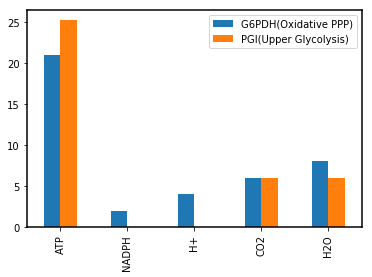

In [6]:
model = model_cons.copy()

with model:
    model.reactions.PGI.knock_out()
    sol=model.optimize()
    series1 = sol.fluxes[['ATPM', 'GTHOr', 'EX_h_c', 'EX_co2_c', 'EX_h2o_c']]
    series1.name = 'G6PDH(Oxidative PPP)'

with model:
    model.reactions.G6PDH2r.knock_out()

    sol = model.optimize()
    series2 = sol.fluxes[['ATPM', 'GTHOr', 'EX_h_c', 'EX_co2_c', 'EX_h2o_c']]
    series2.name = 'PGI(Upper Glycolysis)'

df = pd.DataFrame([series1, series2])
df.columns = ['ATP', 'NADPH', 'H+', 'CO2', 'H2O']
df.abs().T.plot(kind='bar')

### 2) Characterizing the solution space: Flux variability analysis (FVA)

Maximize and minimize the flux through G6PDH2r and PGI for values of ATPM form 0 to the maximum values
 - **Note** minimization is performed by passing 'minimize' into `optimize` method
 
Use the `plot_fva` to visualize results. Store the outpus in lists corresponding to those in `plot_fva`.

In [7]:
def plot_fva(atpm_values, max_g6pdh_values, max_pgi_values, min_g6pdh_values, min_pgi_values):
    """
    Parameters
    ----------
    atpm_values : list
        list of ATPM flux values from 0 to max
        
    max_g6pdh_values : list
        list of maximum G6PDH2r flux values at the ATPM fluxes in atpm_values
    max_pgi_values : list
        list of maximum PGI flux values at the ATPM fluxes in atpm_values

    min_g6pdh_values : list 
        list of minimum G6PDH2r flux values at the ATPM fluxes in atpm_values

    min_pgi_values : list
        list of minimum PGI flux values at the ATPM fluxes in atpm_values

    """
    plt.fill_between(atpm_values, max_g6pdh_values, min_g6pdh_values, 
                     label='G6PDH(ppp)', alpha=.7)
    plt.fill_between(atpm_values, max_pgi_values, min_pgi_values, 
                     label='PGI(glycolysis)', alpha=.7)
    plt.legend()
    plt.xlabel('ATPM flux')
    plt.ylabel('Range of possible fluxes')

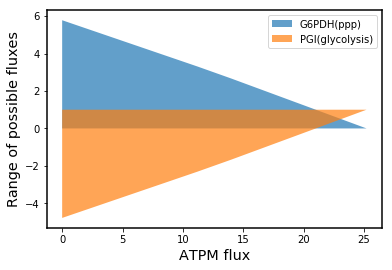

In [8]:
combined = model_cons.copy()
rxn = 'ATPM'
var_rxn = 'G6PDH2r'
var_rxn_2 = 'PGI'
combined.objective = rxn
obj = combined.optimize().objective_value
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).lower_bound = bound
    combined.reactions.get_by_id(rxn).upper_bound = bound

    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

### 3) Characterizing solution space (sampling)

Use the `cobra.sampling` method to sample the model 1000 times.

**Note**: this returns a dataframe. You can visualize the solutions with `df[['G6PDH2r', 'PGI']].hist()`

In [9]:
combined =model_cons.copy()
df = cobra.sampling.sample(combined, 1000)

Text(0.5,0,'PGI flux')

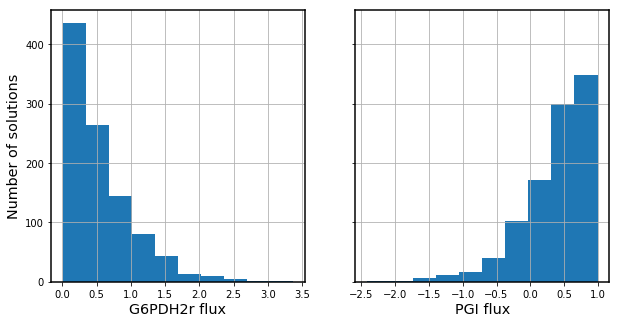

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['G6PDH2r'].hist(ax=ax)
ax.set_xlabel('G6PDH2r flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['PGI'].hist()
ax.set_xlabel('PGI flux')

## C) Characteristics of core energy metabolism
### 1) Carbon yield of gluconeogenic substrats
Assess the carbon yield and gluconeogenesis pathway used to generate g6p from each carbon containing metabolite

**Approach**
1. Add exchange reaction for g6p_c to use as the objective reaction
  - Make sure the lower bound is set to 0 (i.e., g6p_c -> )

2. Set glucose uptake to zero

3. Iterate through all model metabolites
 - Skip those with no C molecules in formula
 - Can check for this using, for example `model.metabolites.co2_c.elements.get('C', 0)`. This will return 0 if the metabolite does not contain any carbons
 
4. Check for an existing exchange reaction for the metabolite. 
 - If it does not not exist, add one
 - Set the lower bound of the exchange reaction to 1

5. Set objective to EX_g6p_c and optimize
 - Use `cobra.flux_analysis.pfba` for optimization. This will return the most parsimonious solution (i.e., the sum of flux values in the model will be minimized)


6. Calculate the carbon yield of g6p per substrate
 - Can return the number of carbons per mol of substrate using command above (i.e.,
 `mol_c_substrate = model.metabolites.co2_c.elements.get('C', 0)`)
 -  `sol.fluxes['EX_g6p_c'] * 6 / mol_c_substrate`
 
7. Compute the absolute value of the flux through two mitochondrial transporters: MALtm and PEPtm
 
7. Save solution in a pandas `DataFrame` structured like below:

| Met ID      | g6p yield | MALtm |PEPtm |
| :-------------: |:-------------:|:-------------:| :-------------:|
| glc__D_c |  | |  |
| pep_c |  |   |  |
| . |  |   |  |
| . |  |   |  |

8. Use `plot_carbon_yield` to visualize solution


**Note:** make sure to either remove any newly added exchanges (or set the exchange to zero) before computing the yield for the next metabolite. You can also use the model as a context as described in https://cobrapy.readthedocs.io/en/latest/getting_started.html#Making-changes-reversibly-using-models-as-contexts 

In [13]:
def plot_carbon_yield(input_df):
    
    fig, ax = plt.subplots(1,1)
    input_df = input_df.rename({'g6p yield': r'G6P Yield ($\mathrm{\frac{mol\ C_{G6P}}{mol\ C_{precursor}}}$)',
                                      'MALtm': 'Malate transport flux',
                                      'PEPtm': 'PEP transport flux'}, axis=1)
    ax = input_df.plot(kind='bar', figsize=(12.5, 5), ax=ax)
    ax.legend(fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontdict={'size': 14})
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title('Gluconeogenic compounds in glycolysis, PPP, and TCA', size=15)
    fig.tight_layout()

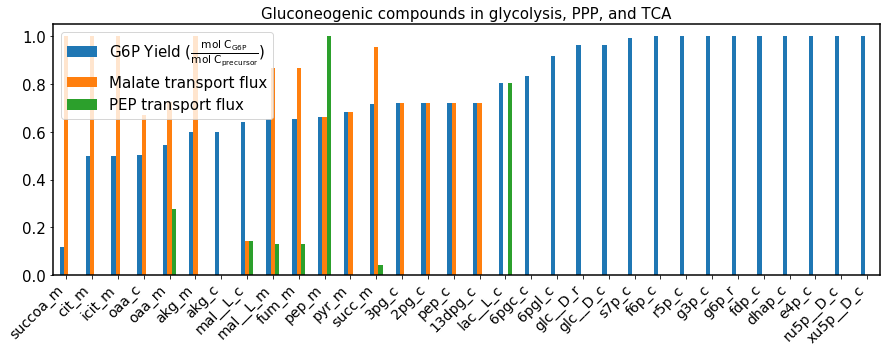

In [14]:
glc_per_mol = pd.DataFrame()
model = model_cons.copy()
model.add_boundary(model.metabolites.g6p_c)
model.reactions.EX_g6p_c.lower_bound = 0
model.reactions.EX_glc__D_c.lower_bound = 0
for m in model.metabolites:
    if m.elements.get('C', 0) == 0:
        continue
    with model:

        if 'EX_' + m.id in model.reactions:
            pass
        else:
            r = cobra.Reaction('EX_' + m.id)
            model.add_reaction(r)
            r.build_reaction_from_string(m.id + '->')
        model.reactions.get_by_id('EX_' + m.id).lower_bound = -1
        model.objective = 'EX_g6p_c'
        sol = cobra.flux_analysis.pfba(model)
            
        if sol.objective_value == 0:
            continue
        mol_c_substrate = m.elements['C'] 
        mol_glc_per_mol = sol.fluxes['EX_g6p_c'] * 6 / mol_c_substrate

        glc_per_mol.loc[m.id, 'g6p yield'] = mol_glc_per_mol
        glc_per_mol.loc[m.id, 'MALtm'] = abs(sol.fluxes['MALtm'])
        glc_per_mol.loc[m.id, 'PEP transport flux'] = sol.fluxes['PEPtm']

glc_per_mol = glc_per_mol.sort_values(by='g6p yield')

plot_carbon_yield(glc_per_mol)

### 2) Common pitfalls: neglecting metabolite transport

In [12]:
model = model_cons.copy()
def mitochondrial_exchange(reaction):
    cytosolic = False
    mitochondrial = False
    for m in reaction.metabolites:
        if m.id[-2:] == '_c':
            cytosolic = True
        if m.id[-2:] == '_m':
            mitochondrial = True
    # If reaction contains both mitochondrial and
    # cytosolic metabolite, return True
    if cytosolic and mitochondrial:
        return True
    else:
        return False

out = pd.DataFrame()
flux = model.optimize().objective_value
out.loc['All Transport', 'ATPM'] = flux
for r in model.reactions:
    with model:
        if mitochondrial_exchange(r):
            r.knock_out()
            flux = model.optimize().objective_value
            out.loc[r.id, 'ATPM'] = flux

Text(0.5,0,'Transport reaction knocked out')

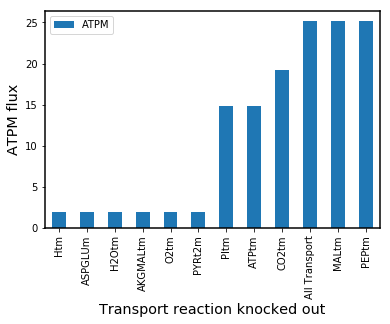

In [13]:
ax = out.sort_values("ATPM").plot(kind='bar')
ax.set_ylabel('ATPM flux')
ax.set_xlabel('Transport reaction knocked out')

In [22]:
model.reactions.EX_lac__L_c.knock_out()

In [23]:
model.reactions.LDH_L

Reaction identifier,LDH_L
Name,L-lactate dehydrogenase
Memory address,0x0112158208
Stoichiometry,lac__L_c + nad_c <=> h_c + nadh_c + pyr_c L-Lactate + Nicotinamide adenine dinucleotide <=> H+ + Nicotinamide adenine dinucleotide - reduced +
GPR,(3945_AT1 and 3939_AT1) or 160287_AT1 or 3948_AT2 or 3939_AT1 or 3948_AT1 or 55293_AT1 or 3945_AT...
Lower bound,-1000.0
Upper bound,1000.0


In [19]:
df = model.optimize().to_frame()

In [28]:
df[df['fluxes'].abs() > .001]

,fluxes,reduced_costs
NADH2_u10mi,8.0,-2.220446e-16
SUCD1m,2.0,0.000000e+00
FADH2ETC,2.0,0.000000e+00
CYOR_u10mi,10.0,2.220446e-16
CYOOm2i,5.0,0.000000e+00
ATPS4mi,17.6,-3.330669e-16
CSm,2.0,0.000000e+00
ACONTm,2.0,0.000000e+00
ICDHxm,2.0,0.000000e+00
AKGDm,2.0,0.000000e+00


In [29]:
model.metabolites.nadh_c.summary()

,,PERCENT,FLUX,REACTION_STRING
RXN_STAT,ID,,,
PRODUCING,GAPD,100.0,2.0,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
CONSUMING,MDH,100.0,2.0,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
